In [1]:
import sys
import os

# Add the parent directory of 'vegetation-period-NDVI' to the sys.path
sys.path.append(os.path.abspath(os.path.join("..")))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ee
import geemap 
import seaborn as sns
from datetime import datetime
from typing import List
import matplotlib as mpl
from scipy import stats


from validate_dowscaled_et import prepare_data_for_plotting
from utils.plot_config import set_plot_style
from time_series_metrics import calculate_metrics

from utils.utils import print_collection_dates

import re

import warnings
warnings.filterwarnings("ignore")

In [3]:
ee.Initialize(project="thurgau-irrigation")

## Some helper functions

In [4]:
def store_collection_dates(collection: ee.ImageCollection) -> pd.DataFrame:
    """
    Store the dates of all images in an ImageCollection in a pandas DataFrame.

    Args:
        collection (ee.ImageCollection): The input image collection.

    Returns:
        pd.DataFrame: A pandas DataFrame containing the dates in datetime format.
    """
    dates = collection.aggregate_array("system:time_start")
    formatted_dates = dates.map(lambda d: ee.Date(d).format("YYYY-MM-dd"))
    date_list = formatted_dates.getInfo()

    date_df = pd.DataFrame({"date": pd.to_datetime(date_list)})

    return date_df

In [5]:
def aggregate_time_series(
    daily_data: pd.DataFrame,
    validation_dates: pd.DataFrame,
    aggregation_type: str = "mean",
) -> pd.DataFrame:
    """
    Aggregate daily time series data based on sample dates.

    Args:
        daily_data (pd.DataFrame): Daily time series with date index and 'evapotranspiration_[mm/d]' column.
        validation_dates (pd.DataFrame): DataFrame with 'date' column containing validation dates.
        aggregation_type (str): Type of aggregation to perform ('mean' or 'sum'). Defaults to 'mean'.

    Returns:
        pd.DataFrame: Aggregated data with sample dates and aggregated values.
    """
    daily_data.index = pd.to_datetime(daily_data.index)

    # Convert validation_dates to datetime and sort
    validation_dates["date"] = pd.to_datetime(validation_dates["date"])
    validation_dates = validation_dates.sort_values("date")

    # Create bins for grouping
    bins = validation_dates["date"].tolist() + [
        daily_data.index.max() + pd.Timedelta(days=1)
    ]

    # Cut the daily data into groups based on the bins
    daily_data["group"] = pd.cut(
        daily_data.index, bins=bins, labels=validation_dates["date"], right=False
    )

    # Group by the cut and calculate the aggregation
    if aggregation_type == "sum":
        aggregated_data = (
            daily_data.groupby("group")["evapotranspiration_[mm/d]"].sum().reset_index()
        )
        aggregated_data.columns = ["date", "sum_evapotranspiration_[mm/d]"]
    else:
        aggregated_data = (
            daily_data.groupby("group")["evapotranspiration_[mm/d]"]
            .mean()
            .reset_index()
        )
        aggregated_data.columns = ["date", "average_evapotranspiration_[mm/d]"]

    return aggregated_data

In [6]:
def set_negative_to_zero(image: ee.Image) -> ee.Image:
    """
    Set all negative values in an image to zero.

    Args:
        image (ee.Image): The input image.

    Returns:
        ee.Image: The image with all negative values set to zero.
    """
    return image.where(image.lt(0), 0)

In [7]:
def merge_et_collections(years: List[int]) -> ee.ImageCollection:
    """
    Merge ET collections for multiple years.
    
    Args:
        years (list): List of years to process.
    
    Returns:
        ee.ImageCollection: Merged ET collection for all years.
    """
    collections = [
        ee.ImageCollection(f"projects/thurgau-irrigation/assets/Thurgau/ET_WaPOR_10m_dekadal_{year}")
        .sort("system:time_start")
        .map(set_negative_to_zero)
        for year in years
    ]
    
    # Merge all collections into one
    merged_collection = collections[0]
    for collection in collections[1:]:
        merged_collection = merged_collection.merge(collection)
    
    return merged_collection

In [8]:
def extract_pixel_values(
    image_collection: ee.ImageCollection,
    point: ee.Geometry.Point,
    band: str = "downscaled",
) -> ee.FeatureCollection:
    """
    Extract the pixel value of the 'downscaled' band for each image in the collection
    at the specified point, with error handling for missing timestamps.

    Args:
        image_collection (ee.ImageCollection): The input image collection.
        point (ee.Geometry.Point): The point at which to extract values.
        band (str): The band to extract values from. Defaults to 'downscaled'.

    Returns:
        ee.FeatureCollection: A feature collection where each feature represents an image
                              and contains the pixel value of the "band" at the point.
    """

    def extract_value(image: ee.Image) -> ee.Feature:
        # Select the 'downscaled' band
        image_band = image.select(band)

        # Get the scale of the 'downscaled' band
        scale = image_band.projection().nominalScale()

        # Extract the pixel value at the point
        pixel_value = image_band.reduceRegion(
            reducer=ee.Reducer.first(),
            geometry=point,
            scale=scale,
            bestEffort=True,
        ).get(band)

        # Retrieve the image acquisition time
        time_start = image.get("system:time_start")

        # Handle potential null time_start
        formatted_date = ee.Algorithms.If(
            ee.Algorithms.IsEqual(time_start, None),
            None,
            ee.Date(time_start).format("YYYY-MM-dd"),
        )

        return ee.Feature(
            None,
            {
                "pixel_value": pixel_value,
                "date": formatted_date,
                "system:time_start": time_start,
            },
        )

    # Map the extraction function over the image collection
    return ee.FeatureCollection(image_collection.map(extract_value))

In [9]:
def aggregate_to_monthly(collection: ee.ImageCollection) -> ee.ImageCollection:
    """
    Aggregate an image collection to monthly images, weighted by the number of days each image represents.

    Args:
        collection (ee.ImageCollection): Input collection with 'downscaled' band.

    Returns:
        ee.ImageCollection: Monthly aggregated image collection.
    """

    def aggregate_month(year, month, images):
        images = ee.List(images)
        start_date = ee.Date.fromYMD(year, month, 1)
        end_date = start_date.advance(1, "month")
        days_in_month = end_date.difference(start_date, "day")

        def weight_image(i):
            i = ee.Number(i)
            image = ee.Image(images.get(i))
            next_image = ee.Image(images.get(i.add(1)))
            date = ee.Date(image.get("system:time_start"))
            next_date = ee.Date(
                ee.Algorithms.If(
                    i.eq(images.size().subtract(1)),
                    end_date,
                    next_image.get("system:time_start"),
                )
            )
            weight = next_date.difference(date, "day")
            # Cast the 'downscaled' band to a consistent float type
            return (
                image.select("downscaled")
                .cast({"downscaled": "float"})
                .multiply(weight)
            )

        weighted_sum = ee.ImageCollection.fromImages(
            ee.List.sequence(0, images.size().subtract(1)).map(weight_image)
        ).sum()

        return weighted_sum.set(
            {"system:time_start": start_date.millis(), "year": year, "month": month}
        )

    # Get unique year-month combinations
    dates = collection.aggregate_array("system:time_start")
    unique_year_months = dates.map(lambda d: ee.Date(d).format("YYYY-MM")).distinct()

    def process_year_month(ym):
        ym = ee.String(ym)
        year = ee.Number.parse(ym.slice(0, 4))
        month = ee.Number.parse(ym.slice(5, 7))
        start_date = ee.Date.fromYMD(year, month, 1)
        end_date = start_date.advance(1, "month")

        monthly_images = collection.filterDate(start_date, end_date)
        return aggregate_month(
            year, month, monthly_images.toList(monthly_images.size())
        )

    aggregated = ee.ImageCollection.fromImages(
        unique_year_months.map(process_year_month)
    )

    projection = collection.first().projection()
    scale = collection.first().projection().nominalScale()

    # Ensure consistent float type for the entire collection
    return aggregated.map(
        lambda img: img.cast({"downscaled": "float"}).setDefaultProjection(
            projection, None, scale
        )
    ).sort("system:time_start")

In [10]:
def update_image_timestamp(
    collection: ee.ImageCollection, image_id: str, date_str: str
) -> ee.ImageCollection:
    """
    Update the 'system:time_start' for a specific image in the collection.

    Args:
        collection (ee.ImageCollection): The original image collection.
        image_id (str): The ID of the image to update.
        date_str (str): The date string in 'YYYY-MM-DD' format.

    Returns:
        ee.ImageCollection: Updated image collection.
    """
    # Convert the date string to a timestamp
    date = datetime.strptime(date_str, "%Y-%m-%d")
    timestamp = int(date.timestamp() * 1000)  # Convert to milliseconds

    # Function to update the image if it matches the ID
    def update_image(image):
        return ee.Algorithms.If(
            ee.String(image.get("system:index")).equals(image_id),
            image.set("system:time_start", timestamp),
            image,
        )

    # Map the update function over the collection
    updated_collection = collection.map(update_image)

    return updated_collection

### Import validation data and WaPOR ET data

In [11]:
years_to_process = [2018, 2019, 2020, 2021]

et_collection = merge_et_collections(years_to_process)
dates_for_validation = store_collection_dates(et_collection)

In [12]:
image_id = "2_WaPOR_ET_downscaled_2021-02_D2"
date_str = "2021-02-11"

updated_et_collection = update_image_timestamp(et_collection, image_id, date_str)
et_collection = updated_et_collection

In [13]:
et_collection.first().propertyNames().getInfo()

['system:index',
 'system:time_start',
 'system:footprint',
 'system:version',
 'system:id',
 'system:asset_size',
 'system:bands',
 'system:band_names']

In [14]:
# Fix image with missing date
image_id = "2_WaPOR_ET_downscaled_2021-02_D2"
image = et_collection.filter(ee.Filter.eq('system:index', image_id)).first()

date_str = "2021-02-11"
date = datetime.strptime(date_str, "%Y-%m-%d")

image_with_date = image.set("system:time_start", date.timestamp() * 1000)
image_with_date.date().getInfo()

{'type': 'Date', 'value': 1612998000000}

In [15]:
rietholzbach_validation_et_collection = ee.FeatureCollection("projects/thurgau-irrigation/assets/Thurgau/ETFluxNet/ET_timeseries_rietholzbach_2017_2021").sort("system:time_start")

In [16]:
rietholzbach_validation_df = geemap.ee_to_df(rietholzbach_validation_et_collection)

In [17]:
rietholzbach_validation_df["date"] = pd.to_datetime(rietholzbach_validation_df["date_[YYYYmmdd]"])
rietholzbach_validation_df = rietholzbach_validation_df.drop(columns=["date_[YYYYmmdd]"])
rietholzbach_validation_df = rietholzbach_validation_df.set_index("date")
rietholzbach_validation_df = rietholzbach_validation_df.resample("D").asfreq()
rietholzbach_validation_df = rietholzbach_validation_df.interpolate(method='time')

In [18]:
rietholzbach_validation_ET = aggregate_time_series(rietholzbach_validation_df, dates_for_validation)
rietholzbach_validation_ET['date'] = pd.to_datetime(rietholzbach_validation_ET['date'])
rietholzbach_validation_ET["average_evapotranspiration_[mm/d]"] = rietholzbach_validation_ET["average_evapotranspiration_[mm/d]"].round(0)

In [19]:
point = rietholzbach_validation_et_collection.first().geometry()
raster_collection = extract_pixel_values(et_collection, point)

In [20]:
waport_df = geemap.ee_to_df(ee.FeatureCollection(raster_collection))
waport_df["evapotranspiration[mm/d]"] = (waport_df["pixel_value"] / 100).round(0)
waport_df["date"] = pd.to_datetime(waport_df["date"])

### Visually validate the WAPOR ET data

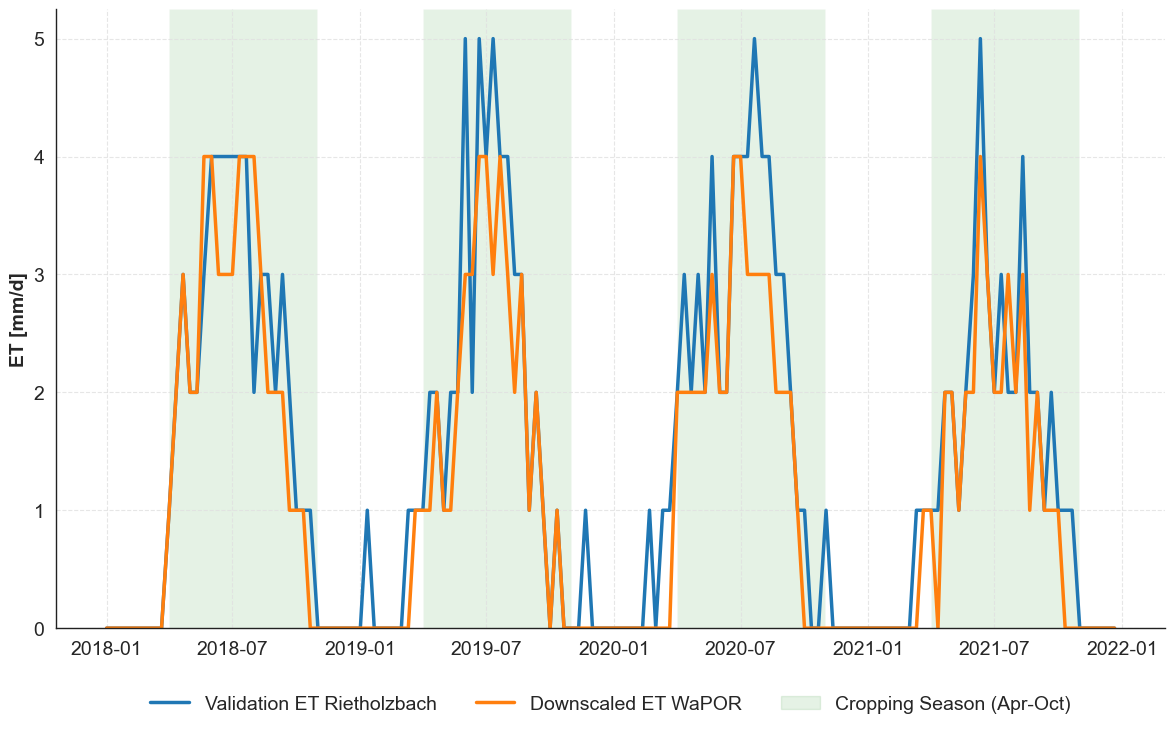

In [21]:
import matplotlib.patches as mpatches

set_plot_style()  # Assuming this function is defined elsewhere

plt.figure(figsize=(12, 8))  # Increased height to accommodate bottom legend

# Plot the data
sns.lineplot(data=rietholzbach_validation_ET, x="date", y="average_evapotranspiration_[mm/d]", label="Validation ET Rietholzbach", color="#1f77b4")
sns.lineplot(data=waport_df, x="date", y="evapotranspiration[mm/d]", label="Downscaled ET WaPOR", color="#ff7f0e")

# Set labels
plt.xlabel("")
plt.ylabel("ET [mm/d]")

plt.ylim(bottom=0)  

# Add green background for April to October
for year in range(rietholzbach_validation_ET['date'].dt.year.min(), rietholzbach_validation_ET['date'].dt.year.max() + 1):
    plt.axvspan(pd.Timestamp(f"{year}-04-01"), pd.Timestamp(f"{year}-10-31"), 
                facecolor='green', alpha=0.1, zorder=0)

# Create a custom patch for the legend
green_patch = mpatches.Patch(color='green', alpha=0.1, label='Cropping Season (Apr-Oct)')

# Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(green_patch)

# Place the legend at the bottom with 3 columns
plt.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, -0.15), 
            ncol=3, borderaxespad=0.)

# Adjust layout to prevent cutting off the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Adjust bottom margin to fit the legend


plt.savefig("/Users/cooper/Desktop/Hydrosolutions/ETblue-estimation /images/ET_validation/WaPOR_validation_Rietholzbach_10d_aggregate.png", dpi=300, bbox_inches="tight")
plt.show()

### Quantitative validation

In [22]:
metrics = calculate_metrics(rietholzbach_validation_ET['average_evapotranspiration_[mm/d]'], waport_df['evapotranspiration[mm/d]'])

In [23]:
metrics

{'R-squared': 0.7,
 'Correlation Coefficient': 0.9,
 'Dynamic Time Warping Distance': 5.3,
 'Mean Absolute Error': 0.4,
 'Root Mean Square Error': 0.7,
 'Normalized Root Mean Square Error': 0.2}

## Comparing WaPOR ET with Rietholzbach ET and Landsat ET

### Getting the landsat image and preparing it for plotting

In [36]:
ET_landsat_cantons = ee.ImageCollection("projects/thurgau-irrigation/assets/ETlandsatmonthly")

In [37]:
landsat_ET_fc = extract_pixel_values(ET_landsat_cantons, point, band="ET")
landsat_ET_df = geemap.ee_to_df(landsat_ET_fc)

In [38]:
landsat_ET_df

landsat_ET_df['date'] = pd.to_datetime(landsat_ET_df['date'])

# Set all dates to the first day of their respective months
landsat_ET_df['date'] = landsat_ET_df['date'].dt.to_period('M').dt.to_timestamp()

landsat_ET_df["evapotranspiration[mm/month]"] = landsat_ET_df["pixel_value"]

In [39]:
# Filter landsat_ET_df for dates between 2018-01-01 and 2021-12-31
landsat_ET_df = landsat_ET_df[
    (landsat_ET_df["date"] >= "2018-01-01") & (landsat_ET_df["date"] <= "2021-12-31")
]

# Set NaN values to 0
landsat_ET_df["evapotranspiration[mm/month]"] = landsat_ET_df[
    "evapotranspiration[mm/month]"
].fillna(0)

### Resampling dekadal WaPOR data to monthly data. The resampling is done by multiplying the dekadal data by the number of days in each dekad and then summing the values for each month.

In [40]:
wapor_monthly_et = aggregate_to_monthly(et_collection)
wapor_monthly_et_fc = extract_pixel_values(wapor_monthly_et, point)
waport_monthly_df = geemap.ee_to_df(ee.FeatureCollection(wapor_monthly_et_fc))
waport_monthly_df["evapotranspiration[mm/month]"] = waport_monthly_df["pixel_value"] / 100
waport_monthly_df["date"] = pd.to_datetime(waport_monthly_df["date"])

In [41]:
dates_for_validation = store_collection_dates(wapor_monthly_et)

### Resample Rietholzbach validation data to monthly

In [42]:
rietholzbach_monthly_ET_df = aggregate_time_series(rietholzbach_validation_df, dates_for_validation, aggregation_type="sum")
rietholzbach_monthly_ET_df.rename(columns={"sum_evapotranspiration_[mm/d]": "sum_evapotranspiration_[mm/month]"}, inplace=True)

### Plotting the validation

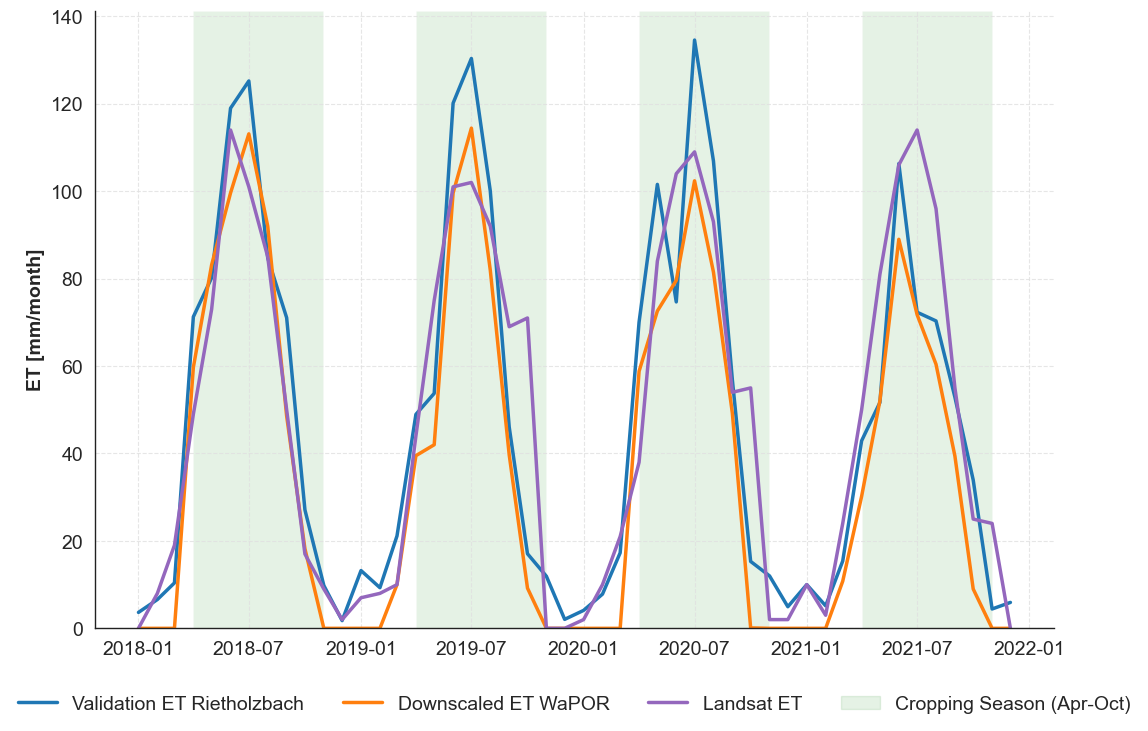

In [44]:
plt.figure(figsize=(12, 8))  

# Plot the data
sns.lineplot(
    data=rietholzbach_monthly_ET_df,
    x="date",
    y="sum_evapotranspiration_[mm/month]",
    label="Validation ET Rietholzbach",
    color="#1f77b4",
)
sns.lineplot(
    data=waport_monthly_df,
    x="date",
    y="evapotranspiration[mm/month]",
    label="Downscaled ET WaPOR",
    color="#ff7f0e",
)
sns.lineplot(
    data=landsat_ET_df,
    x="date",
    y="evapotranspiration[mm/month]",
    label="Landsat ET",
    color="#9467bd"
)

# Set labels
plt.xlabel("")
plt.ylabel("ET [mm/month]")

plt.ylim(bottom=0)

# Add green background for April to October
for year in range(
    rietholzbach_monthly_ET_df["date"].dt.year.min(),
    rietholzbach_monthly_ET_df["date"].dt.year.max() + 1,
):
    plt.axvspan(
        pd.Timestamp(f"{year}-04-01"),
        pd.Timestamp(f"{year}-10-31"),
        facecolor="green",
        alpha=0.1,
        zorder=0,
    )

# Create a custom patch for the legend
green_patch = mpatches.Patch(
    color="green", alpha=0.1, label="Cropping Season (Apr-Oct)"
)

# Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(green_patch)

# Place the legend at the bottom with 3 columns
plt.legend(
    handles=handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,
    borderaxespad=0.0,
)

# Adjust layout to prevent cutting off the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Adjust bottom margin to fit the legend


plt.savefig("/Users/cooper/Desktop/Hydrosolutions/ETblue-estimation /images/ET_validation/WaPOR_Landsat_validation_Rietholzbach_monthly.png", dpi=300, bbox_inches="tight")
plt.show()

In [47]:
metrics = calculate_metrics(rietholzbach_monthly_ET_df['sum_evapotranspiration_[mm/month]'], waport_monthly_df['evapotranspiration[mm/month]'])
print(metrics)
metrics = calculate_metrics(rietholzbach_monthly_ET_df['sum_evapotranspiration_[mm/month]'], landsat_ET_df['evapotranspiration[mm/month]'])
print(metrics)

{'R-squared': 0.9, 'Correlation Coefficient': 1.0, 'Dynamic Time Warping Distance': 83.1, 'Mean Absolute Error': 11.2, 'Root Mean Square Error': 13.3, 'Normalized Root Mean Square Error': 0.1}
{'R-squared': 0.8, 'Correlation Coefficient': 0.9, 'Dynamic Time Warping Distance': 80.7, 'Mean Absolute Error': 12.8, 'Root Mean Square Error': 18.3, 'Normalized Root Mean Square Error': 0.2}
